# <font color='firebrick'><center>Idx Stats Report</center></font>
### This report provides information from the output of samtools idxstats tool. It outputs the number of mapped reads per chromosome/contig.
<br>



,Total reads,Total mapped reads,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,chr11,chr12,chr13,chr14,chr15,chr16,chr17,chr18,chr19,chrX,chrY,chrM
X_5Aza_24h_1_L001.hisat,7437667,7200029,779303,546886,379809,229448,310594,461180,308738,281218,286705,181069,351882,360956,92406,161455,260164,269724,379364,114458,418371,165070,2778,287592
X_5Aza_24h_1_L002.hisat,7552317,7307000,793487,549922,389162,232259,316664,465153,313286,287814,291909,184913,357501,365529,92865,164968,263095,273643,387541,115982,424075,167278,2787,291122
X_5Aza_24h_1_L003.hisat,7243114,6995244,756270,537030,370059,224219,303034,448173,299220,274132,278901,176830,342718,348595,90297,157431,252440,263612,369361,111407,402719,159820,2718,278354
X_5Aza_24h_1_L004.hisat,7186408,6939347,752385,518454,368829,221030,301536,442862,296763,274149,276130,176436,340093,348904,89232,158111,251594,260691,366269,110355,400940,159663,2906,276354
X_5Aza_24h_2_L001.hisat,13115973,12723016,1343404,933509,613557,363576,512828,816460,516590,463359,492499,301074,611601,629952,139093,262705,449615,496150,682489,180473,778649,288326,4627,676471
X_5Aza_24h_2_L002.hisat,13413531,13006239,1372358,964048,626753,369695,524288,832270,527542,474526,502433,307443,627169,639950,142162,267230,458529,507456,700171,184557,796580,294151,4844,688662
X_5Aza_24h_2_L003.hisat,12921135,12504184,1318492,931907,602429,363560,505038,799462,504110,454314,485427,294526,600297,616164,136962,257166,441616,485611,669992,176680,763785,285854,4904,664204
X_5Aza_24h_2_L004.hisat,12820365,12435022,1318399,903794,601533,350081,502608,795644,504997,455882,484018,295629,597497,614971,137632,256043,440663,484401,665994,175829,759491,283363,4798,660101
X_63R_7d_1_L001.hisat,6689689,6444681,687008,516618,327062,216013,266937,422852,273128,269526,275417,166800,365885,324484,87143,133146,244692,242095,339756,109145,403053,150261,3018,223265
X_63R_7d_1_L002.hisat,6813263,6562007,697058,527552,334475,219518,271435,431524,279679,273382,279364,168508,373929,329763,87590,135496,252479,247796,344400,112032,408388,153119,3273,226630


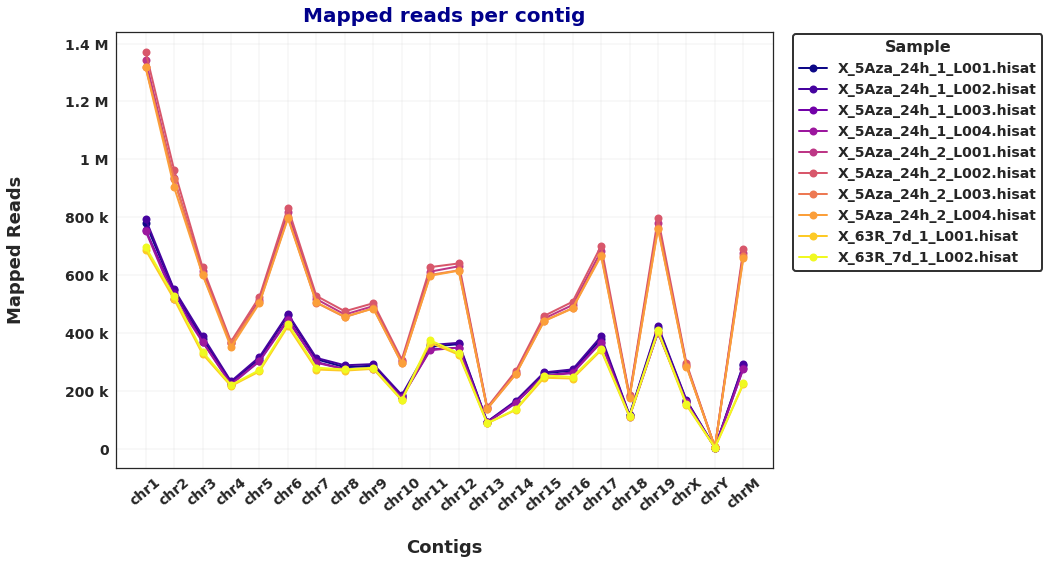

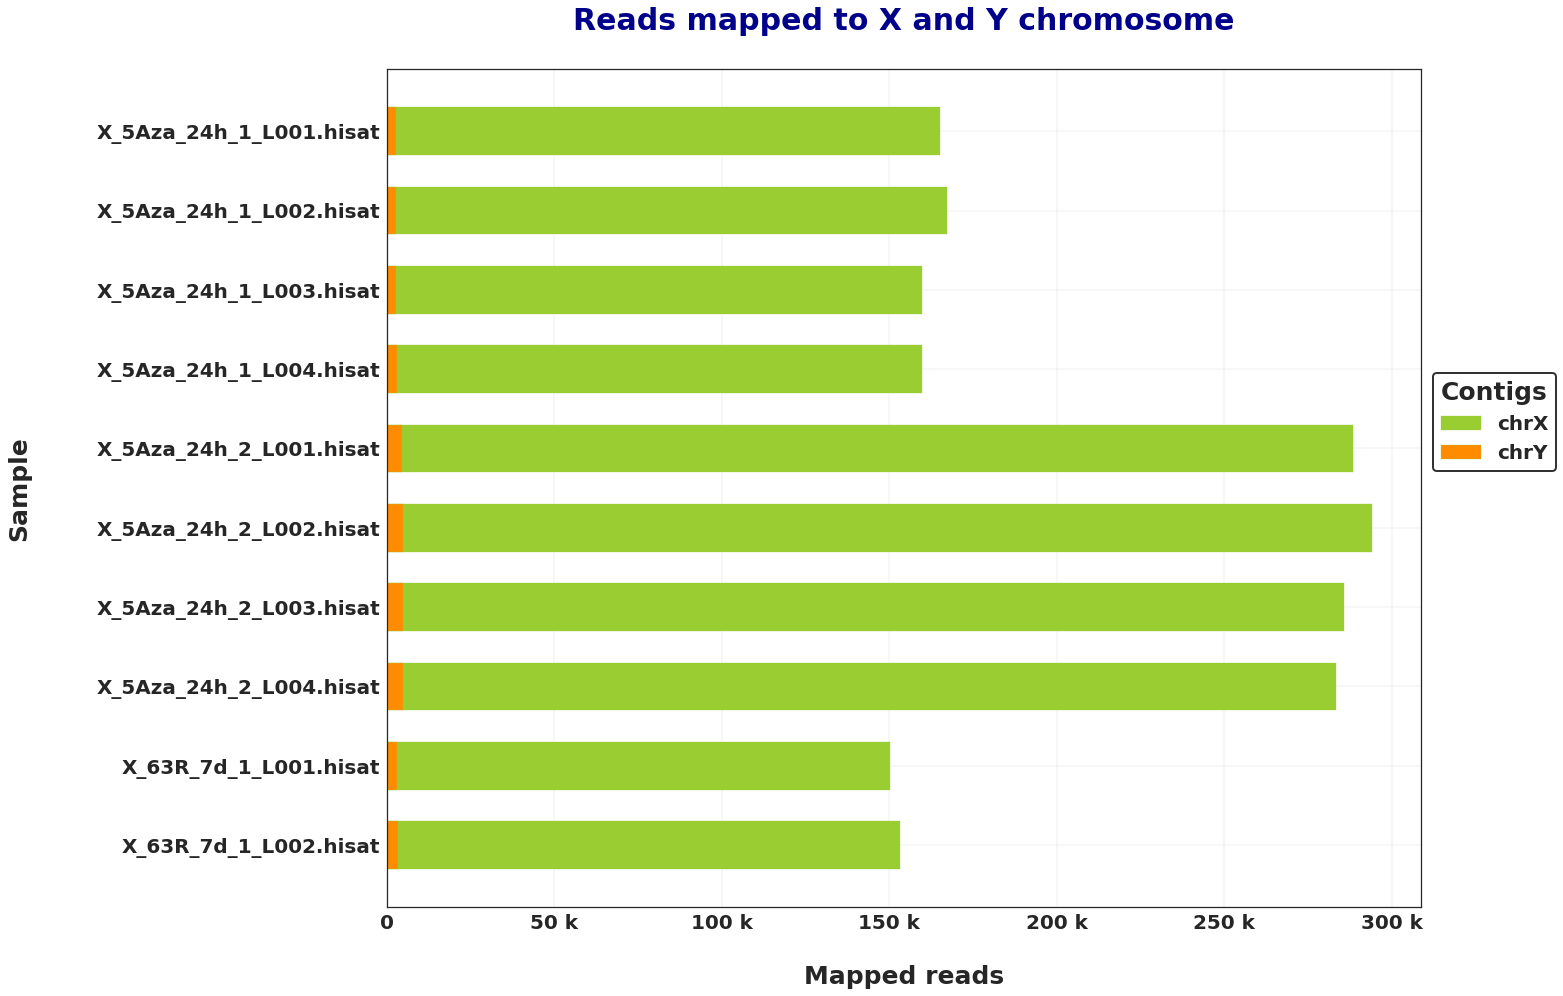

In [3]:
from IPython.display import display, Markdown
from IPython.display import HTML
import IPython.core.display as di
import csv
import numpy as np
import zlib
import CGAT.IOTools as IOTools
import itertools as ITL
import os
import string
import pandas as pd
import sqlite3
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages  # noqa: E402
#mpl.use('Agg')  # noqa: E402
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.font_manager as font_manager
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib import rc, font_manager
import CGAT.Experiment as E
import math
from random import shuffle
import matplotlib as mpl
import datetime
import seaborn as sns
import nbformat



##################################################
#Plot customization
#plt.ioff()
plt.style.use('seaborn-white')
#plt.style.use('ggplot')
title_font = {'size':'20','color':'darkblue', 'weight':'bold', 'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'size':'18', 'weight':'bold'}
#For summary page pdf
'''To add description page
plt.figure() 
plt.axis('off')
plt.text(0.5,0.5,"my title",ha='center',va='center')
pdf.savefig()
'''
#Panda data frame cutomization
pd.options.display.width = 80
pd.set_option('display.max_colwidth', -1)

chr_feature=['total_reads','total_mapped_reads',
                  'chr1','chr2','chr3','chr4',
                  'chr5','chr6','chr7','chr8',
                  'chr9','chr10','chr11','chr12',
                  'chr13','chr14','chr15','chr16',
                  'chr17','chr18','chr19','chrX',    
                  'chrY','chrM']
chr_index=['Total reads','Total mapped reads',
                  'chr1','chr2','chr3','chr4',
                  'chr5','chr6','chr7','chr8',
                  'chr9','chr10','chr11','chr12',
                  'chr13','chr14','chr15','chr16',
                  'chr17','chr18','chr19','chrX',    
                  'chrY','chrM']
colors_category = ['red','green','darkorange','yellowgreen', 'pink', 'gold', 'lightskyblue', 
                   'orchid','darkgoldenrod','skyblue','b', 'red', 
                   'darkorange','grey','violet','magenta','cyan',
                   'hotpink','mediumslateblue']
threshold = 5

def hover(hover_color="#ffff99"):
    return dict(selector="tr:hover",
                props=[("background-color", "%s" % hover_color)])

def y_fmt(y, pos):
    decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9 ]
    suffix  = ["G", "M", "k", "" , "m" , "u", "n"  ]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    #print(val, signf)
                    if str(val).split(".")[1] == "0":
                       return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])

                #return y
    return y

def getTables(dbname):
    '''
    Retrieves the names of all tables in the database.
    Groups tables into dictionaries by annotation
    '''
    dbh = sqlite3.connect(dbname)
    c = dbh.cursor()
    statement = "SELECT name FROM sqlite_master WHERE type='table'"
    c.execute(statement)
    tables = c.fetchall()
    print(tables)
    c.close()
    dbh.close()
    return 

def readDBTable(dbname, tablename):
    '''
    Reads the specified table from the specified database.
    Returns a list of tuples representing each row
    '''
    dbh = sqlite3.connect(dbname)
    c = dbh.cursor()
    statement = "SELECT * FROM %s" % tablename
    c.execute(statement)
    allresults = c.fetchall()
    c.close()
    dbh.close()
    return allresults

def getDBColumnNames(dbname, tablename):
    dbh = sqlite3.connect(dbname)
    res = pd.read_sql('SELECT * FROM %s' % tablename, dbh)
    dbh.close()
    return res.columns


def plotBar(df,samplename):
    fig, ax = plt.subplots()
    ax.set_frame_on(True)
    ax.xaxis.set_major_formatter(FuncFormatter(y_fmt))
    colors=['yellowgreen','darkorange']
    for ii in range(0,df.shape[0]):
        plt.barh(ii,df['chrX'][ii],color=colors[0], align="center",height=0.6,edgecolor=colors[0])
        plt.barh(ii,df['chrY'][ii],color=colors[1], align="center",height=0.6,edgecolor=colors[0])
    fig = plt.gcf()
    fig.set_size_inches(20,14)
    plt.yticks(fontsize =20,weight='bold')
    plt.yticks(range(df.shape[0]),df['track'])
    plt.xticks(fontsize =20,weight='bold')
    ax.grid(which='major', linestyle='-', linewidth='0.3')
    plt.ylabel("Sample",labelpad=65,fontsize =25,weight='bold')
    plt.xlabel("\nMapped reads",fontsize =25,weight='bold')
    plt.title("Reads mapped to X and Y chromosome\n",fontsize =30,weight='bold',color='darkblue')
    plt.gca().invert_yaxis()
    legend_properties = {'weight':'bold','size':'20'}
    leg = plt.legend(chr_feature[21:23],title="Contigs",prop=legend_properties,bbox_to_anchor=(1.14,0.65),frameon=True)
    leg.get_frame().set_edgecolor('k')
    leg.get_frame().set_linewidth(2)
    leg.get_title().set_fontsize(25)
    leg.get_title().set_fontweight('bold')
    plt.tight_layout()
    plt.savefig(''.join([samplename,'.png']),bbox_inches='tight',pad_inches=0.6)
    plt.show()
    return fig

def displayTable(plotdf,name):
    # Display table
    styles = [
    hover(),
    dict(selector="th", props=[("font-size", "130%"),
                               ("text-align", "center"),
                              ]),                               
    dict(selector="td", props=[("font-size", "120%"),
                               ("text-align", "center"),
                              ]),
    dict(selector="caption", props=[("caption-side", "top"),
                                   ("text-align", "center"),
                                   ("font-size", "100%")])
    ]
    df1 = (plotdf.style.set_table_styles(styles).set_caption(name))
    display(df1)
    print("\n\n")
    
def plot_idxstats(newdf,df,samplename):
        
        fig,ax = plt.subplots()
        ax.grid(which='major', linestyle='-', linewidth='0.25')
        ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
        index=list(range(newdf.shape[1]))
        colors = plt.cm.plasma(np.linspace(0,1,newdf.shape[0]))
        for ii in range(0,newdf.shape[0]):
            plt.plot(index,newdf.iloc[ii],linewidth=2,color=colors[ii],linestyle="-",marker='o',fillstyle='full',markersize=8)
        fig = plt.gcf()
        fig.set_size_inches(11,8)
        plt.xticks(index,chr_feature[2:24],fontsize = 14,weight='bold')
        plt.yticks(fontsize = 14,weight='bold')
        labels = ax.get_xticklabels()
        plt.setp(labels, rotation=40)
        legend_properties = {'weight':'bold','size':'14'}
        leg = plt.legend(df['track'],title="Sample",prop=legend_properties,bbox_to_anchor=(1.42,1.01),frameon=True)
        leg.get_frame().set_edgecolor('k')
        leg.get_frame().set_linewidth(2)
        leg.get_title().set_fontsize(16)
        leg.get_title().set_fontweight('bold')
        plt.xlabel('\nContigs',**axis_font)
        plt.ylabel('Mapped Reads',**axis_font,labelpad=40)
        plt.title("Mapped reads per contig", **title_font)
        plt.tight_layout()
        plt.savefig(''.join([samplename,'.png']),bbox_inches='tight',pad_inches=0.6)
        print("\n\n")
        plt.show()
        return fig
        
def idxStatsReport(dbname, tablename):
    trans = pd.DataFrame(readDBTable(dbname,tablename))
    trans.columns = getDBColumnNames(dbname,tablename)
    df=trans
    #print(df)
    #newdf = df[df.columns[0:25]] 
    newdf = df[chr_feature[2:24]]
    #print(newdf)
    plotdf = df[chr_feature]
    plotdf.columns = chr_index
    plotdf.index = [df['track']]
    #del plotdf.index.name
    pdf=PdfPages("idx_stats_summary.pdf")
    displayTable(plotdf,"Idx Full Stats")
    fig = plot_idxstats(newdf,df,"idx_full_stats")
    pdf.savefig(fig,bbox_inches='tight',pad_inches=0.6)
    print("\n\n\n")
    fig = plotBar(df,"idxStats_X_Y_mapped_reads")
    pdf.savefig(fig,bbox_inches='tight',pad_inches=0.6)
    pdf.close()
#getTables("csvdb")
idxStatsReport("../csvdb","idxstats_reads_per_chromosome")




